# Decision Tree

This notebook contain some practice and experimetns related to decision tree model, pruning and early stopping regularizations.

Dataset used in this practice - Rain in Australia https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package



## Imports / Data download and read

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path

from mlpeople.io.google_drive import download_file_iss

file_path = Path('./downloads/weatherAUS.csv')

# download only if file does NOT exist
if not file_path.exists():
    print("Downloading file...")
    download_file_iss(
        '1AUZu5Jv5EjfjoW9dFazDa4OEnymfS-Rt',
        output_path=str(file_path)
    )
else:
    print("File already exists. Skipping download.")

# read csv
raw_df = pd.read_csv(file_path)
display(raw_df.shape)
display(raw_df.head())
display(raw_df.info())

(145460, 23)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

None

In [2]:
from mlpeople.eda.reporting import describe_dataframe

describe_dataframe(raw_df)

,column_id,data_type,unique_values,missing_values,mean,std,min,max
0,Date,object,3436,0,NaN,NaN,NaN,NaN
1,Location,object,49,0,NaN,NaN,NaN,NaN
2,MinTemp,float64,389,1485,12.19,6.40,-8.5,33.9
3,MaxTemp,float64,505,1261,23.22,7.12,-4.8,48.1
4,Rainfall,float64,681,3261,2.36,8.48,0.0,371.0
5,Evaporation,float64,358,62790,5.47,4.19,0.0,145.0
6,Sunshine,float64,145,69835,7.61,3.79,0.0,14.5
7,WindGustDir,object,16,10326,NaN,NaN,NaN,NaN
8,WindGustSpeed,float64,67,10263,40.04,13.61,6.0,135.0
9,WindDir9am,object,16,10566,NaN,NaN,NaN,NaN


## Train / Test split

In [3]:
raw_df.dropna(subset=['RainTomorrow'], inplace=True)

In [4]:
year = pd.to_datetime(raw_df.Date).dt.year

train_df = raw_df[year <= 2015]
test_df = raw_df[year > 2015]

input_cols = list(train_df.columns)[1:-1]
target_col = 'RainTomorrow'

train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

## Base Decision Tree model

In [5]:
from sklearn.tree import DecisionTreeClassifier

from mlpeople.preprocessing.pipelining import get_model_pipeline

model_dt = DecisionTreeClassifier(random_state=42)

model_pipeline = get_model_pipeline(
    model=model_dt,
    num_impute_strategy="mean",
    cat_impute_strategy="constant",
    scaler_skip=True
)

model_pipeline.fit(train_inputs, train_targets)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers c

In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix

train_preds = model_pipeline.predict(train_inputs)
test_preds = model_pipeline.predict(test_inputs)

print(f"Train accuracy: {accuracy_score(train_targets, train_preds)}")
print(f"Test accuracy: {accuracy_score(test_targets, test_preds)}")

Train accuracy: 0.9999827911098874
Test accuracy: 0.7760837760837761


### Feature Importance

In [7]:
importance_df = pd.DataFrame({
    'feature': model_pipeline.named_steps["preprocessing"].get_feature_names_out(),
    'importance': model_pipeline.named_steps["model"].feature_importances_
}).sort_values('importance', ascending=False)
importance_df.head(10)

,feature,importance
9,num__Humidity3pm,0.260824
11,num__Pressure3pm,0.061758
2,num__Rainfall,0.058823
5,num__WindGustSpeed,0.053720
4,num__Sunshine,0.047172
8,num__Humidity9am,0.037919
10,num__Pressure9am,0.037518
0,num__MinTemp,0.036238
1,num__MaxTemp,0.035317
14,num__Temp9am,0.035018


### Tree Visualization

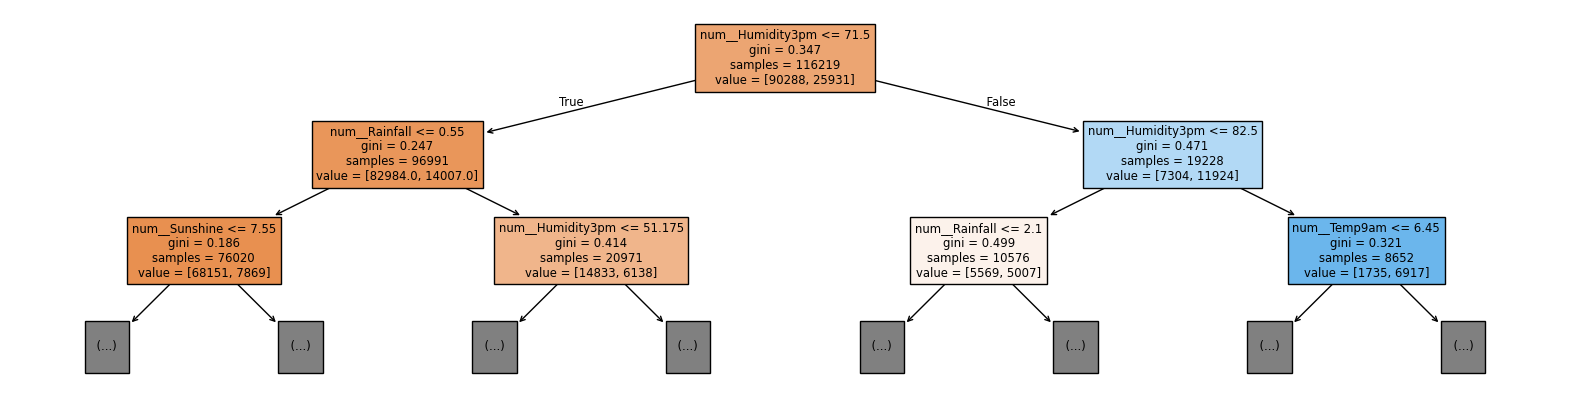

In [8]:
from sklearn.tree import plot_tree, export_text
plt.figure(figsize=(20,5))
plot_tree(
    model_pipeline.named_steps["model"], 
    feature_names=model_pipeline.named_steps["preprocessing"].get_feature_names_out(),
    max_depth=2, filled=True
);

## Hyperparameters tuning

In [9]:
X_train_processed = model_pipeline.named_steps["preprocessing"].transform(train_inputs)
X_test_processed = model_pipeline.named_steps["preprocessing"].transform(test_inputs)

In [10]:
from mlpeople.optimization.experiments.decision_tree_experiments import (
    evaluate_decision_tree,
    plot_errors,
    run_decision_tree_experiment,
)

### Max Depth

In [11]:
%%time

errors_df = pd.DataFrame([
    evaluate_decision_tree(
        X_train_processed,
        train_targets,
        X_test_processed,
        test_targets,
        dynamic_params={"max_depth": md}
    )
    for md in range(1, 21)
])

CPU times: user 18.4 s, sys: 289 ms, total: 18.7 s
Wall time: 18.8 s


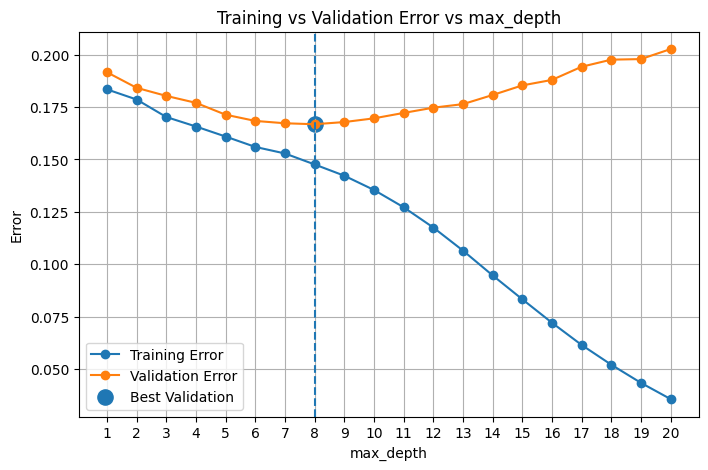

Best max_depth: 8
Lowest Validation Error: 0.1667


In [12]:
plot_errors(errors_df, "max_depth")

### Max Depth and Min Sample Split

In [13]:
%%time

errors_df = pd.DataFrame([
    evaluate_decision_tree(
        X_train_processed,
        train_targets,
        X_test_processed,
        test_targets,
        dynamic_params={
            "max_depth": md,
            "min_samples_split": mss
        }
    )
    for md in range(4, 13)
    for mss in [2, 5, 10, 16]
])


CPU times: user 28.1 s, sys: 281 ms, total: 28.3 s
Wall time: 28.4 s


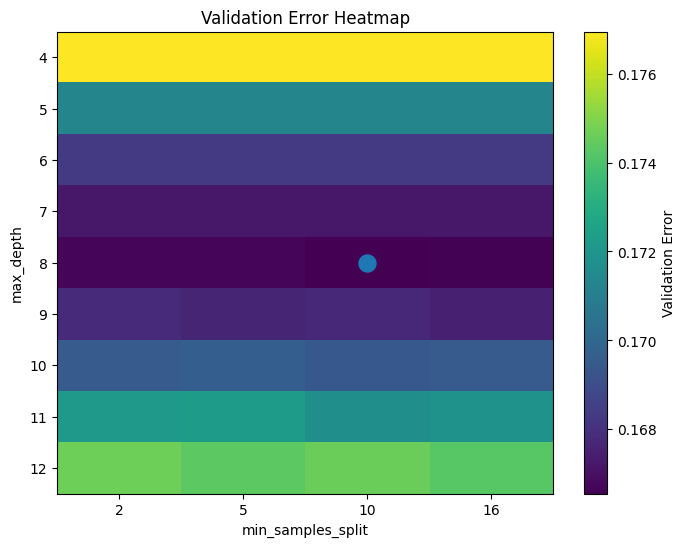

Best max_depth: 8
Best min_samples_split: 10
Lowest Validation Error: 0.1666


In [14]:
plot_errors(errors_df, ["max_depth", "min_samples_split"])

### Min Sample Split & Min Samples Leaf

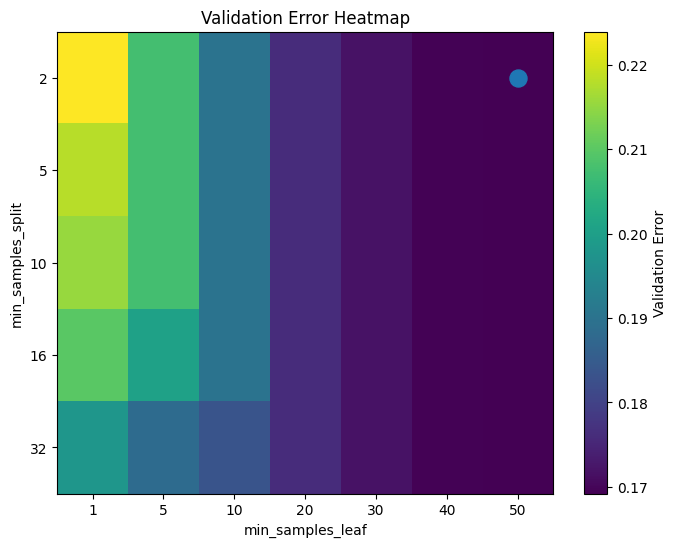

Best min_samples_split: 2
Best min_samples_leaf: 50
Lowest Validation Error: 0.1692
CPU times: user 47.6 s, sys: 381 ms, total: 48 s
Wall time: 48.1 s


In [15]:
%%time

errors_df_mss_msl = run_decision_tree_experiment(
    X_train_processed,
    train_targets,
    X_test_processed,
    test_targets,
    param_grid={
        "min_samples_split": [2, 5, 10, 16, 32],
        "min_samples_leaf": [1, 5, 10, 20, 30, 40, 50],
    },
    plot_params=["min_samples_split", "min_samples_leaf"]
)


### Min Samples Leaf

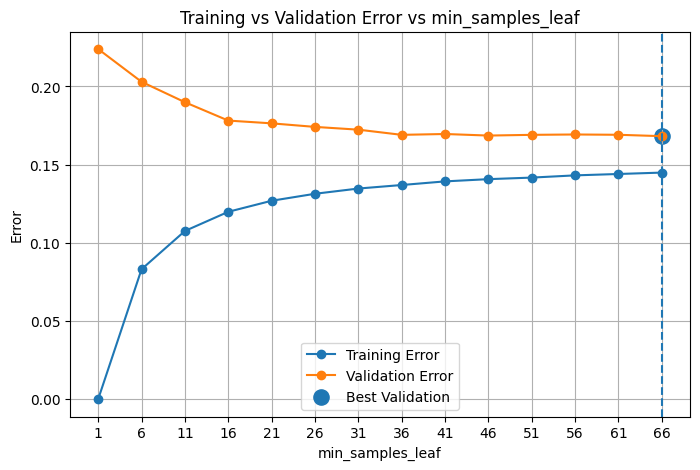

Best min_samples_leaf: 66
Lowest Validation Error: 0.1682
CPU times: user 18.6 s, sys: 256 ms, total: 18.8 s
Wall time: 19.1 s


In [16]:
%%time

errors_df_msl = run_decision_tree_experiment(
    X_train_processed,
    train_targets,
    X_test_processed,
    test_targets,
    param_grid={
        "min_samples_leaf": range(1, 71, 5)
    },
    plot_params=["min_samples_leaf"]
)


### Max leaf nodes

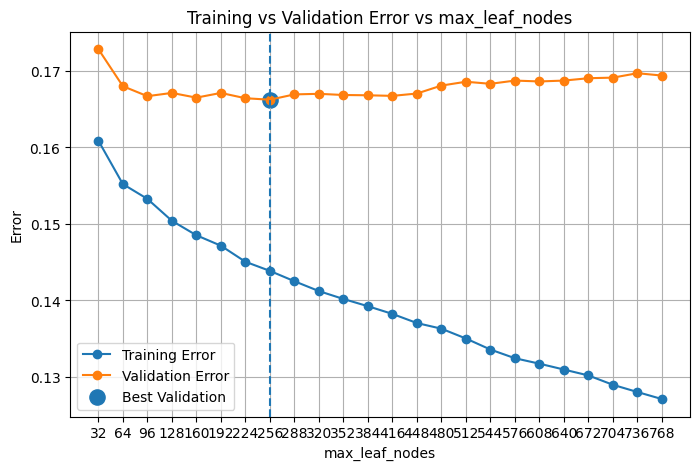

Best max_leaf_nodes: 256
Lowest Validation Error: 0.1662
CPU times: user 22.5 s, sys: 303 ms, total: 22.8 s
Wall time: 23 s


In [17]:
%%time

errors_df_mln = run_decision_tree_experiment(
    X_train_processed,
    train_targets,
    X_test_processed,
    test_targets,
    param_grid={
        "max_leaf_nodes": range(32, 800, 32)
    },
    plot_params=["max_leaf_nodes"]
)


### Max leaf nodes with fixed Max depth

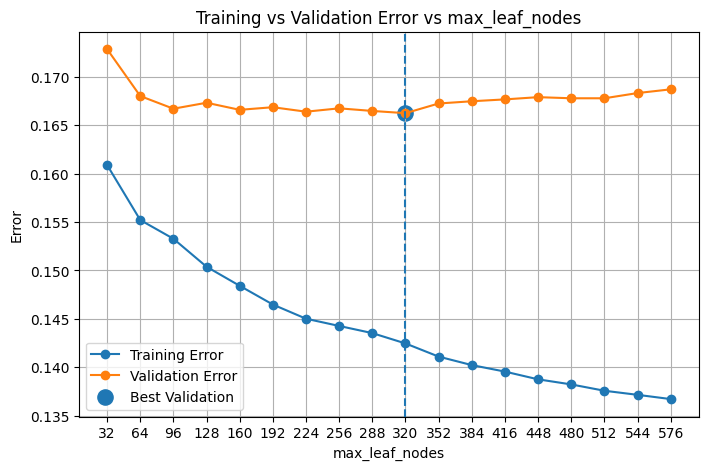

Best max_leaf_nodes: 320
Lowest Validation Error: 0.1662
CPU times: user 15.7 s, sys: 178 ms, total: 15.9 s
Wall time: 15.9 s


In [18]:
%%time

errors_df_mln_fmd = run_decision_tree_experiment(
    X_train_processed,
    train_targets,
    X_test_processed,
    test_targets,
    param_grid={
        "max_leaf_nodes": range(32, 600, 32)
    },
    static_params={
        "max_depth": 10
    },
    plot_params=["max_leaf_nodes"]
)


### Max Depth and Max leaf nodes

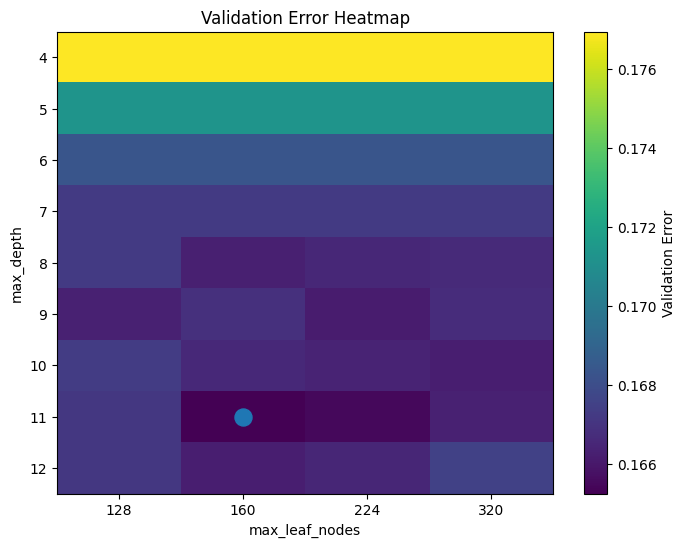

Best max_depth: 11
Best max_leaf_nodes: 160
Lowest Validation Error: 0.1652
CPU times: user 27.2 s, sys: 282 ms, total: 27.4 s
Wall time: 27.5 s


In [19]:
%%time

errors_df_mln_md = run_decision_tree_experiment(
    X_train_processed,
    train_targets,
    X_test_processed,
    test_targets,
    param_grid={
        "max_depth": range(4, 13),
        "max_leaf_nodes": [128, 160, 224, 320]
    },
    plot_params=["max_depth", "max_leaf_nodes"]
)


## Pruning

In [20]:
from mlpeople.optimization.experiments.decision_tree_pruning import prune_decision_tree_experiment

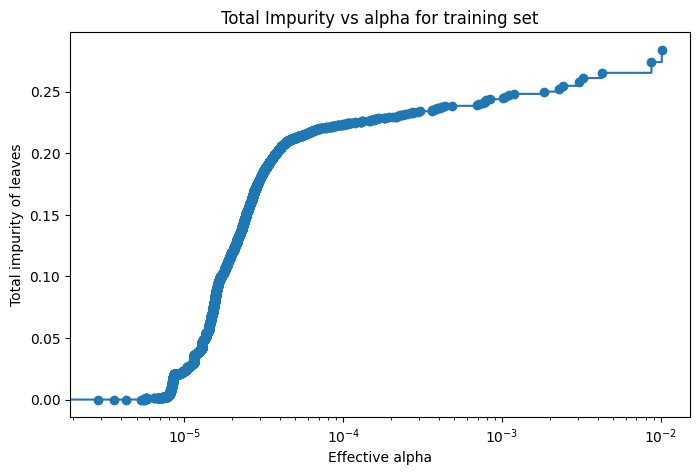

Number of nodes in the last tree: 3 with ccp_alpha: 0.01012297539126486


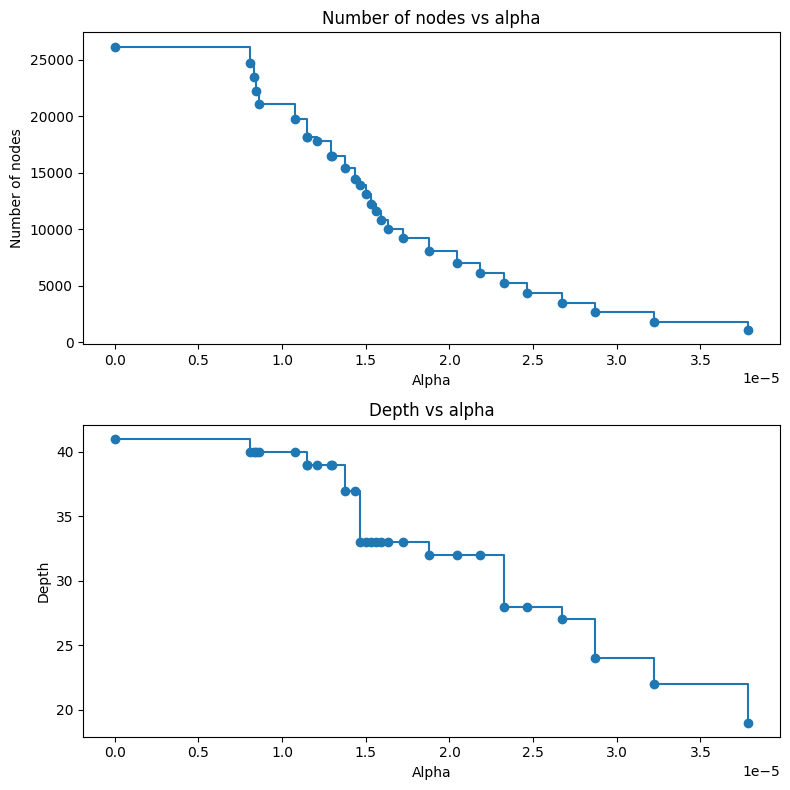

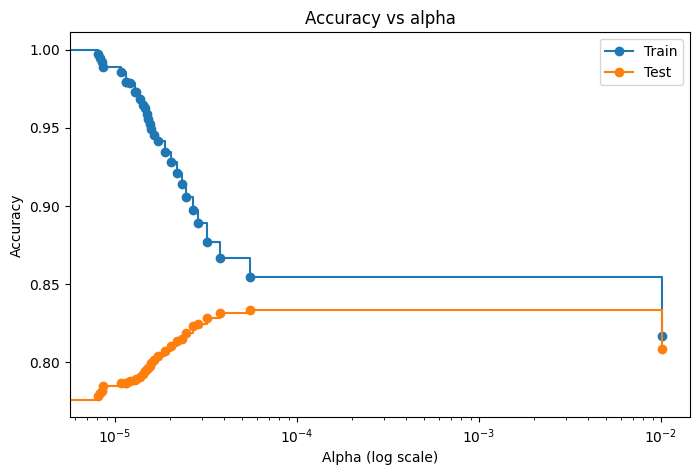

Suggested refine range: indices 5700-5900, alphas 0.000043-0.000098
CPU times: user 57.2 s, sys: 509 ms, total: 57.7 s
Wall time: 58.1 s


In [21]:
%%time 
# ------------------ 1. Run coarse search ------------------
prune_results = prune_decision_tree_experiment(
    X_train_processed,
    train_targets,
    X_test_processed,
    test_targets,
    step_coarse=200  # step over all alphas
)

In [22]:
# Suggested refine range
print("Suggested refine range:", prune_results["refine_range"])

Suggested refine range: (np.int64(5700), np.int64(5901))


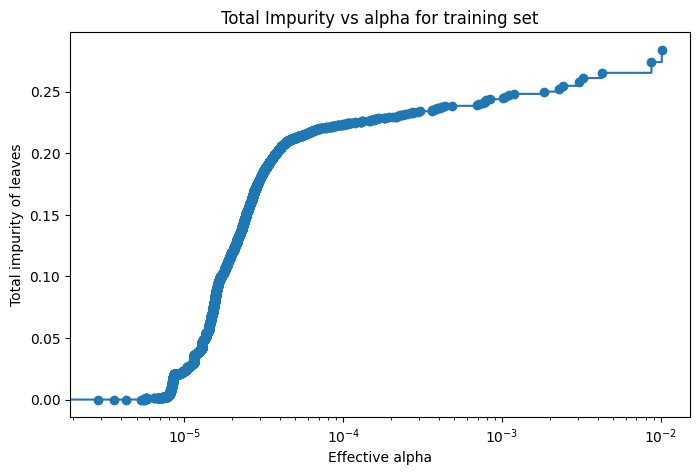

Number of nodes in the last tree: 3 with ccp_alpha: 0.01012297539126486


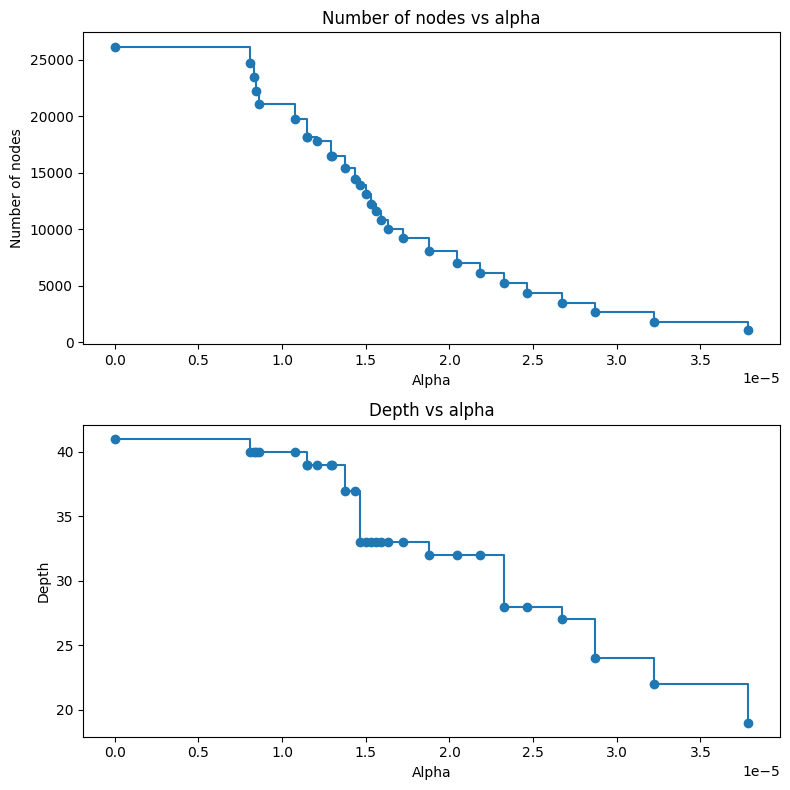

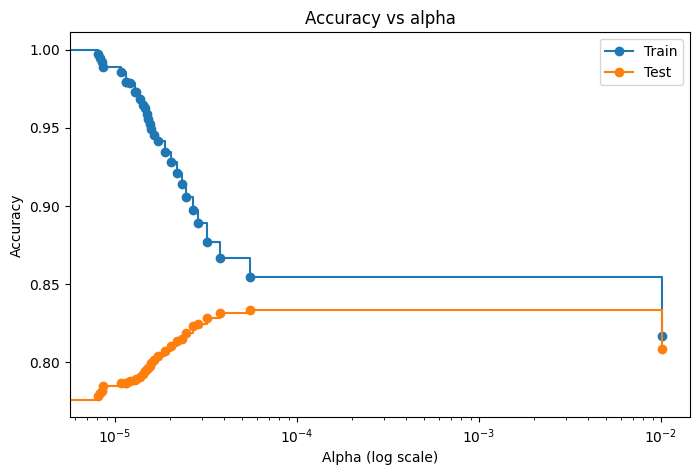

Number of nodes in the last tree: 193 with ccp_alpha: 9.700162913297596e-05


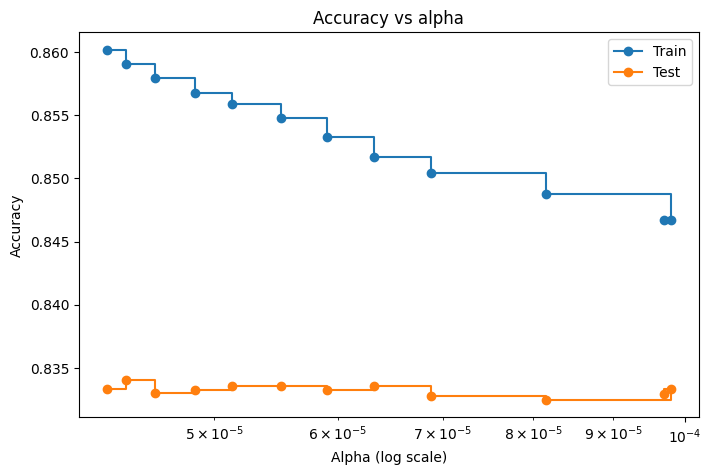

Max test score in refined search: 0.834026334026334
CPU times: user 1min 19s, sys: 732 ms, total: 1min 20s
Wall time: 1min 21s


In [23]:
%%time
# Run refined search manually if you want
refine_range = prune_results["refine_range"]
results_refined = prune_decision_tree_experiment(
    X_train_processed, train_targets, X_test_processed, test_targets,
    step_coarse=200, step_fine=20,
    refine_range=refine_range
)


In [24]:

# ------------------ 4. Analyze results ------------------
# Maximum validation score in refined search
best_idx = np.argmax(results_refined["coarse"]["test_scores"])
best_alpha = results_refined["coarse"]["alphas"][best_idx]
best_score = results_refined["coarse"]["test_scores"][best_idx]

print(f"Best alpha from refined search: {best_alpha}")
print(f"Best validation accuracy: {best_score:.4f}")
print(f"Number of nodes in best tree: {results_refined["coarse"]['clfs'][best_idx].tree_.node_count}")
print(f"Depth of best tree: {results_refined["coarse"]['clfs'][best_idx].tree_.max_depth}")

Best alpha from refined search: 5.5196036951708815e-05
Best validation accuracy: 0.8335
Number of nodes in best tree: 441
Depth of best tree: 15
